# Saving array data to MODFLOW-style binary files


In [1]:
import os
import sys
import shutil
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
numpy version: 1.24.2
matplotlib version: 3.6.3
flopy version: 3.3.7


In [2]:
nlay, nrow, ncol = 1, 20, 10

# temporary directory
temp_dir = TemporaryDirectory()
model_ws = os.path.join(temp_dir.name, "binary_data")

if os.path.exists(model_ws):
    shutil.rmtree(model_ws)

precision = "single"  # or 'double'
dtype = np.float32  # or np.float64

mf = flopy.modflow.Modflow(model_ws=model_ws)
dis = flopy.modflow.ModflowDis(
    mf, nlay=nlay, nrow=nrow, ncol=ncol, delr=20, delc=10
)

Create a linear data array

In [3]:
# create the first row of data
b = np.linspace(10, 1, num=ncol, dtype=dtype).reshape(1, ncol)

# extend data to every row
b = np.repeat(b, nrow, axis=0)

# print the shape and type of the data
print(b.shape)

(20, 10)


Plot the data array

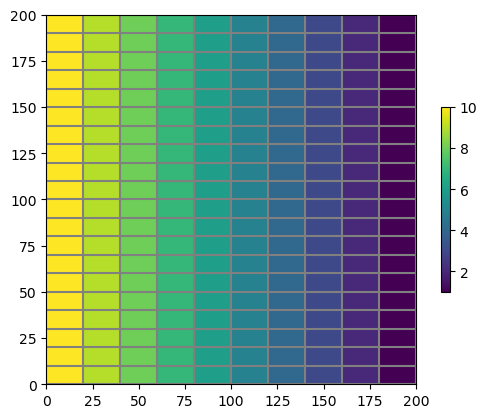

In [4]:
pmv = flopy.plot.PlotMapView(model=mf)
v = pmv.plot_array(b)
pmv.plot_grid()
plt.colorbar(v, shrink=0.5);

Write the linear data array to a binary file

In [5]:
text = "head"

# write a binary data file
pertim = dtype(1.0)
header = flopy.utils.BinaryHeader.create(
    bintype=text,
    precision=precision,
    text=text,
    nrow=nrow,
    ncol=ncol,
    ilay=1,
    pertim=pertim,
    totim=pertim,
    kstp=1,
    kper=1,
)
pth = os.path.join(model_ws, "bottom.bin")
flopy.utils.Util2d.write_bin(b.shape, pth, b, header_data=header)

Read the binary data file

In [6]:
bo = flopy.utils.HeadFile(pth, precision=precision)
br = bo.get_data(idx=0)

Plot the data that was read from the binary file

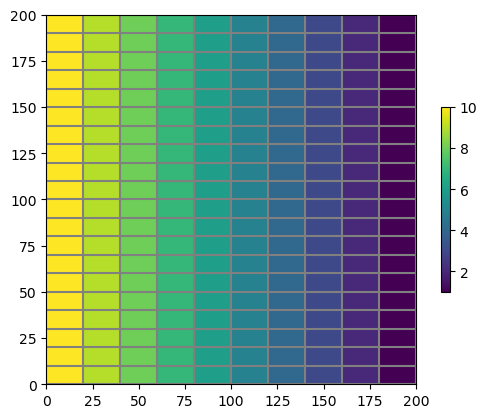

In [7]:
pmv = flopy.plot.PlotMapView(model=mf)
v = pmv.plot_array(br)
pmv.plot_grid()
plt.colorbar(v, shrink=0.5);

Plot the difference in the two values

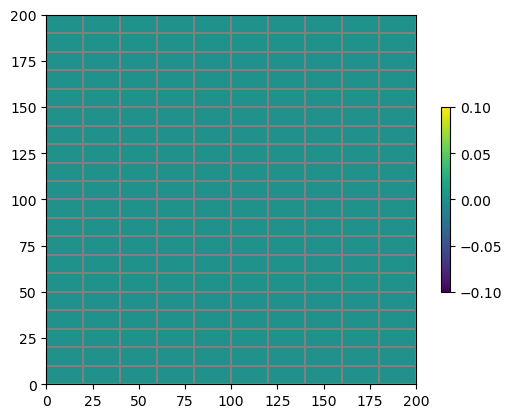

In [8]:
pmv = flopy.plot.PlotMapView(model=mf)
v = pmv.plot_array(b - br)
pmv.plot_grid()
plt.colorbar(v, shrink=0.5);

In [9]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass